In [81]:
from glob import glob
import matplotlib.pyplot as plt
import orbax
from flax.training import orbax_utils ### need this for orbax.checkpoint to be found? 
import numpy as np
from scipy import signal

### Some Preliminary Training Results

In [3]:

orbax_ckptr = orbax.checkpoint.PyTreeCheckpointer()
checkpoint_files = glob('./exps/blues_driver/1/*/ckpt')
print(checkpoint_files)

['./exps/blues_driver/1/Gaussian_blues_driver/ckpt', './exps/blues_driver/1/Wendland_blues_driver/ckpt', './exps/blues_driver/1/MaternOneHalf_blues_driver/ckpt', './exps/blues_driver/1/MaternOneHalf_blues_driver_100kepochs/ckpt']


In [4]:

cp_gauss,cp_wendland,cp_maternonehalf,cp_maternonehalf_100k = (orbax_ckptr.restore(cp_file) for cp_file in checkpoint_files)

In [5]:
train_losses = [cp['losses'][:,0] for cp in [cp_gauss,cp_wendland,cp_maternonehalf]]

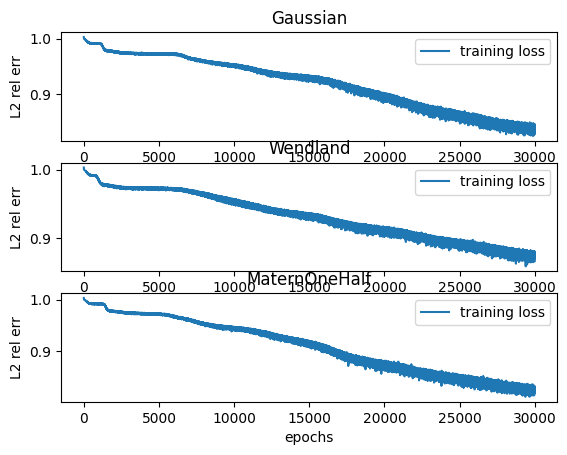

In [6]:
ks = ['Gaussian', 'Wendland', 'MaternOneHalf']

fig,ax = plt.subplots(len(train_losses))
for i,k in enumerate(ks):
    ax[i].plot(train_losses[i],label='training loss')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel('L2 rel err')
    ax[i].legend()
    ax[i].set_title(k)

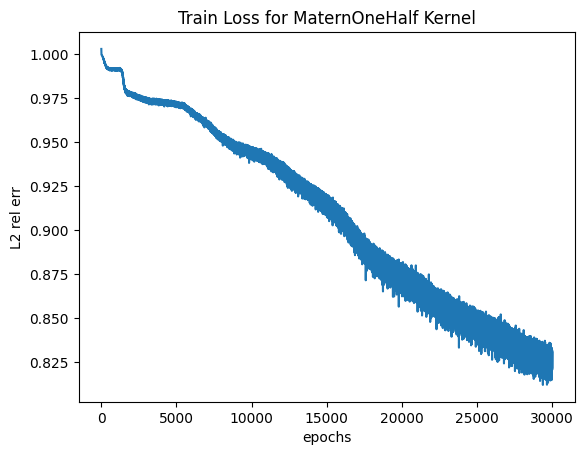

In [22]:
cp_maternonehalf_100k

plt.plot(train_losses[-1])
plt.plot()
plt.xlabel('epochs')
plt.ylabel('L2 rel err')
# plt.legend()
plt.title('Train Loss for MaternOneHalf Kernel')
plt.savefig('./audio_data_plots/matern_onehalf_trainloss_30k_epochs')

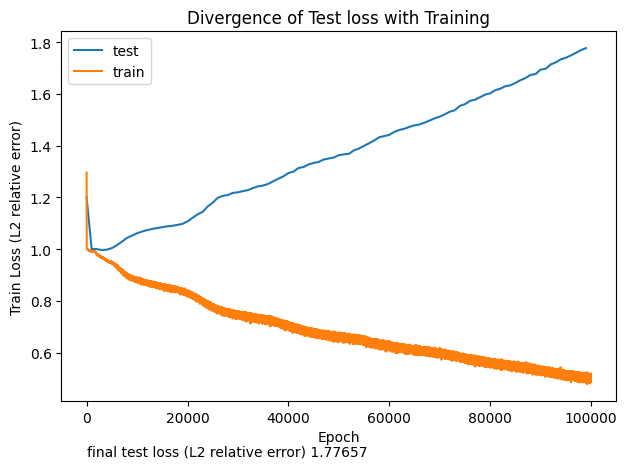

In [31]:
loss_arrays = []
loss_arrays = [cp_maternonehalf_100k['losses'],]
num_plots = len(loss_arrays)
loss_data = loss_arrays[0]

# fig, axs = plt.subplots(num_plots, 1, figsize=(10, 5*num_plots))
train_loss = loss_data[:,0]
test_loss= loss_data[(loss_data[:,1] > 0), 1]
plt.plot(np.arange(0,100000,1000), test_loss,label='test')
plt.plot(train_loss,label='train')
plt.xlabel('Epoch')
plt.ylabel('Train Loss (L2 relative error)')
# .set_ylim([0,.4])
plt.text(0.0,0.2, f'final test loss (L2 relative error) {test_loss[-1]:.5f}')
plt.title('Divergence of Test loss with Training')
plt.tight_layout()

# plt.show()
plt.savefig('./audio_data_plots/convergence')
plt.legend()


### Making model predictions

In [7]:
import sys
from dataset import NumpyLoader, BluesDriverDataset
import ml_collections
import numpy as np
from dataset import (NumpyLoader,
                     BluesDriverDataset)
from jax import random
import jax.numpy as jnp
from models.models import NOpModelNd
from models.mutils import (get_grid, 
                           create_lr_schedule_fn)

from flax.training.train_state import TrainState
import optax
from jax import jit, value_and_grad
from utils import (quad_type_mapping, 
                   param_init_mapping, 
                   non_linearity_mapping,
                   kernel_mapping)


In [36]:


config = ml_collections.ConfigDict(cp_maternonehalf_100k['config'])
config
data = BluesDriverDataset(config)
train = data.get_train_data()
test = data.get_test_data()

key = random.PRNGKey(seed=config.seed)
nx = train.x.shape[1]

train_loader = NumpyLoader(train,
                            batch_size=config.training.batch_size,
                            shuffle=config.training.shuffle)

test_loader = NumpyLoader(test,
                            batch_size=config.testing.batch_size) 

# map from strings in config to objects (like a psd_kernel) for the model to digest
m = config.model
interpolation_kernel = kernel_mapping[m.interpolation_kernel]
integration_kernels = tuple(kernel_mapping[kernel] for kernel in m.integration_kernels.rstrip(',').split(','))
non_linearity = non_linearity_mapping[m.non_linearity]
dense_init = param_init_mapping[m.dense_init]
kernel_init = param_init_mapping[m.kernel_init]
quadrature_fn = quad_type_mapping[m.quad_type]

model = NOpModelNd(quadrature_fn=quadrature_fn,
                    integration_kernels=integration_kernels,
                    interpolation_kernel=interpolation_kernel,
                    non_linearity=non_linearity,
                    dense_init=dense_init,
                    kernel_init=kernel_init,
                    num_quad_pts=m.num_quad_pts,
                    width=m.width,
                    residual_block=m.residual_block,
                    channel_lift=m.channel_lift,
                    channel_lift_size=m.channel_lift_size,
                    num_output_layers=m.num_output_layers,
                    conv=m.conv,
                    secs_per_fn=config.data.secs_per_fn
                    )


### initialize model
f_x = train.x[:1] ### for model init
s = get_grid(f_x.shape[1:],secs_per_fn=config.data.secs_per_fn)
variables = model.init(key,f_x,s)
params = variables['params']

state = TrainState.create(apply_fn=model.apply,
                            params=params,
                            tx=optax.adam(lambda f: f)
                            )







In [58]:
def l2_relative_error(params, data, labels, reduce=None):
    f_x = data
    preds = state.apply_fn({'params': params}, f_x, s)
    if config.data.normalize:
        preds = y_normalizer.decode(preds)  
    num_examples = f_x.shape[0]
    p_norm = lambda x, ord, dim: jnp.sum(jnp.abs(x)**ord, axis=dim)**(1./ord)
    diff_norms = p_norm(preds.reshape(num_examples,-1) - labels.reshape(num_examples,-1), ord=2, dim=1)
    label_norms = p_norm(labels.reshape(num_examples, -1), ord=2,dim=1)
    losses = diff_norms/label_norms
    if reduce=='sum': return preds, jnp.sum(losses) ### sum across the batch 
    if reduce=='mean': return preds, jnp.mean(losses) 
    else: return preds, losses


In [72]:

def eval_step(state, batch): 
    data, labels = batch
    batch_preds, batch_metric = l2_relative_error(state.params, data, labels, reduce='mean')
    return batch_preds, batch_metric ## state ofc not updated in eval


def eval_and_predict(state, dataloader):
    batch_metrics = np.zeros((len(dataloader),))
    preds = np.zeros((len(dataloader), *test.y.shape))
    for i,batch in enumerate(list(dataloader)):
        batch_preds,batch_metric = eval_step(state, batch)
        batch_metrics[i] = batch_metric
        preds[i] = batch_preds
    epoch_metrics = batch_metrics.sum()
    return preds, epoch_metrics.item()

In [77]:
preds, loss = eval_and_predict(state,test_loader)
preds = preds.reshape(-1,4410)

In [78]:
preds.shape

(10, 4410)

### Post processing predictions back to audio!

In [82]:
### output predictions from ML model are N functions  
def postprocess_audio(preds,
                      original_sps=44100,
                      secs_per_fn=1,
                      shuffle=None, 
                      save=False, 
                      save_fp='output.mp3'):
    ## assume shuffle is w/o replacement 
    sampling_rate = preds.shape[1] / secs_per_fn #### each fn is 1 sec so the resolution is the sampl rate 
    if shuffle:
        deshuff = np.array([np.where(shuffle == i)[0] for i in range(len(shuffle))])
        preds = preds[deshuff]
    preds = preds.flatten()
    print(preds.shape)
    upsample = original_sps // sampling_rate
    print(upsample)
    upsampled_audio = signal.upfirdn([1],preds , up=upsample)
    print(upsampled_audio.shape)
    ## stack array now that it is in the right time order...
    if save:
        librosa.output.write_mp3(save_fp, upsampled_audio, original_sps)
    return upsampled_audio, original_sps


audio_array,sr = postprocess_audio(preds,
                                   secs_per_fn=0.1) ### sweeeett

(44100,)
1.0
(44100,)


In [ ]:
import soundfile as sf
save_fp = '/Users/mattlowery/Desktop/blues_driver_proj_results/blues_driver_test_pred.mp3'
sf.write(save_fp, audio_array, sr)